In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nose.tools import *

from scipy.stats import ttest_ind

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
# Write your imports here

# Data Science Project Architecture Lab
## End-to-end project: demonstrating the power of OSEMN. Transition towards modelling. Machine learning basics

### Introduction
On 15 April 1912, the Titanic sank after colliding with an iceberg, killing more than two thirds of the crew and passengers. The dataset provided for you in the `data/` folder contains information about the passengers onboard and which of them survived.

The goal of this lab is to explore the data, prepare it for modelling, and perform a (kind of) simple classification. We'll also explore some basics of practical machine learning such as data preparation, testing and training sets, and model evaluation.

The original dataset is located [here](https://www.kaggle.com/c/titanic/data). You can read the page for more information about the data and variables.

### Problem 1. Read the dataset (1 point)
Read the dataset in the `data/titanic.csv` file into the `titanic_data` variable. Here's a short description of what each column means:
* PassengerId - a unique number identifying each passenger
* Survived - indicator variable: 1 if the passenger survived, 0 otherwise
* Pclass - passenger ticket class (1, 2 or 3). This can be used as an indicator of wealth
* Name
* Sex
* Age
* SibSp - number of siblings / spouses aboard the Titanic
* Parch - number of parents / children aboard the Titanic
* Ticket - ticket number
* Fare - passenger fare (price)
* Cabin - cabin number
* Embarked - port of embarkation: C = Cherbourg, Q = Queenstown, S = Southampton

**Notes on family relationships:**
* Sibling = brother, sister, stepbrother, stepsister
* Spouse = husband, wife (mistresses and fiancés were ignored)
* Parent = mother, father
* Child = daughter, son, stepdaughter, stepson. Some children travelled only with a nanny, therefore Parch = 0 for them.

Set the index column to be "PassengerId". Rename "Pclass" to "Class" and "Parch" to "ParCh". Other than that, the column names aren't too bad (although not Pythonic enough). Don't rename them.

Also, change the "Embarked" column to include the full names of the ports (see the column descriptions).

In [3]:
titanic_data = pd.read_csv("data/titanic.csv", index_col = "PassengerId")
titanic_data = titanic_data.rename(columns={"Pclass": "Class", "Parch": "ParCh"})

In [4]:
assert_is_not_none(titanic_data)

### Problem 2. Inspect and fill missing data (1 point)
See how many records are missing for each column. You can just execute the cell below.

In [5]:
titanic_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Class       891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
ParCh       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


You can see that most of the data is there. We have some people with unknown ages and two people with unknown embarkation ports.

For missing ages, there are three approaches. We can't say right now which will prove the most correct but we'll stick to one.
* Remove people with unknown ages - not desirable, since they are many
* Replace unknown ages with a "centinel" value, e.g. $-1$ - not desirable because this will introduce invalid data which may throw our models off 
* Replace unknown ages with the column mean

We'll stick with the third approach. Replace the `NaN` values in the `Age` column with the column mean.

In [6]:
titanic_data["Age"] = titanic_data["Age"].fillna(titanic_data["Age"].mean())

Let's inspect missing embarkation ports. Store the passengers with unknown embarkation ports in the provided variable.

In [7]:
passengers_with_unknown_embarkation_ports = None
passengers_with_unknown_embarkation_ports = titanic_data[titanic_data["Embarked"].isna()]
passengers_with_unknown_embarkation_ports

,Survived,Class,Name,Sex,Age,SibSp,ParCh,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


We can see there are two such passengers with the same ticket. We can check there are no other passengers with the same ticket number. We have no idea what to do but we might just replace them with the most common embarkation port.

Find out which port was the most common. Replace the two NaN values in the dataset with this port.

In [8]:
most_common_port = titanic_data.Embarked.value_counts().index[0]
titanic_data["Embarked"] = titanic_data["Embarked"].fillna(most_common_port)

In [9]:
# Tests for all operations
assert_false(titanic_data.Age.isnull().any())

assert_is_not_none(passengers_with_unknown_embarkation_ports)
assert_is_not_none(most_common_port)
assert_false(titanic_data.Embarked.isnull().any())

### Problem 3. Remove unnecessary columns (1 point)
The `Cabin` column contains too many missing values. Probably the best we can do with it is remove it. Also, the names and ticket numbers might be useful in another analysis, but not in this case. We're interested in which passengers survived and we have no reason to think that their names might be related to their survival rate. Also, the ticket numbers are somewhat random.

**Note:** It might be interesting to extract the titles of the passengers (e.g. "Mr.", "Miss", "Dr.", etc.) and see whether it correlates to survival rate (e.g. people with higher social status might be more likely to get a boat and survive). But let's not focus on this right now. The class and ticket fare are good enough to indicate social status / wealth.

Remove the `Cabin`, `Name`, and `Ticket` columns.

In [10]:
titanic_data = titanic_data.drop(columns=["Cabin", "Name", "Ticket"])

In [11]:
titanic_data.head()

,Survived,Class,Sex,Age,SibSp,ParCh,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S


In [12]:
assert_equal(titanic_data.shape, (891, 8))

### Problem 4. Explore the data: single variables (1 point)
Let's start with visualizing single variables. 

Try plotting a histogram of all ages with 20 bins. You'll see a kind of unusual peak. Remember that this is because we filled in the missing data with the mean of all ages, and it happens to be right where that peak is.

Also, try plotting a bar chart (or a pie chart) showing the number of passengers who are male and female. To do this, group the dataset by sex and count the number of rows for each group. `num_passengers_by_sex` should be a `pd.Series` with  two indices: "male" and "female".

Finally, try plotting a histogram of fares to see how asymmetric they are.

**Note:** The plots are not autograded, only the data. Feel free to change them, experiment, and add more plots as you see fit. I had quite a lot of fun playing around with different aspects of the data. This is the reason to have EDA, after all :).

**Note 2:** The variables should be really simple to set.

In [13]:
titanic_data.Sex.value_counts()

male      577
female    314
Name: Sex, dtype: int64

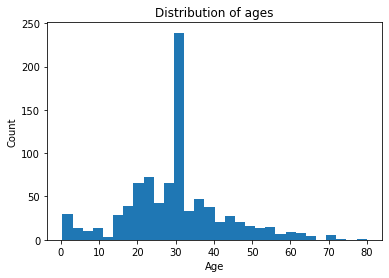

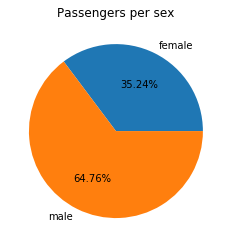

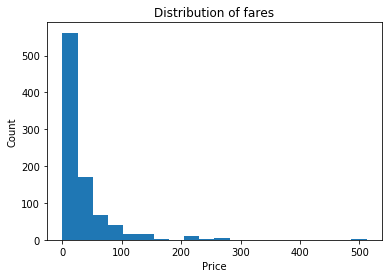

In [14]:
all_ages = None
num_passengers_by_sex = None
all_fares = None

all_ages = titanic_data.Age
num_passengers_by_sex = titanic_data.Sex.value_counts(ascending = True)
all_fares = titanic_data.Fare

plt.hist(all_ages, bins = "fd")
plt.title("Distribution of ages")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

plt.gca().set_aspect("equal")
plt.pie(num_passengers_by_sex, labels = num_passengers_by_sex.index, autopct = "%.2f%%")
plt.title("Passengers per sex")
plt.show()

plt.hist(all_fares, bins = 20)
plt.title("Distribution of fares")
plt.xlabel("Price")
plt.ylabel("Count")
plt.show()

In [15]:
assert_is_not_none(all_ages)
assert_is_not_none(num_passengers_by_sex)
assert_is_not_none(all_fares)

assert_equal(len(all_ages), len(all_fares))
assert_equal(num_passengers_by_sex.index.tolist(), ["female", "male"])

### Problem 5. Explore correlations in the dataset (1 point)
We can play a lot with single variables, groups, etc. But let's focus on correlations now.

One of the first things we can do is check all correlations on all variables, like so:

In [16]:
titanic_data.corr()

,Survived,Class,Age,SibSp,ParCh,Fare
Survived,1.000000,-0.338481,-0.069809,-0.035322,0.081629,0.257307
Class,-0.338481,1.000000,-0.331339,0.083081,0.018443,-0.549500
Age,-0.069809,-0.331339,1.000000,-0.232625,-0.179191,0.091566
SibSp,-0.035322,0.083081,-0.232625,1.000000,0.414838,0.159651
ParCh,0.081629,0.018443,-0.179191,0.414838,1.000000,0.216225
Fare,0.257307,-0.549500,0.091566,0.159651,0.216225,1.000000


Well, there are some correlations but it seems nothing too interesting can be found.

Let's now try some groupings. For example, what percentage of each gender survived? Recall that we calculated the total number of passengers for each gender in the previous exercise.

Filter the `titanic_data` dataset to get only survived passengers and apply the same grouping and counting as you did in the previous exercise. You should get a series with "male" and "female" as the indices.

If your answers are correct, the `print()` statements should run without errors.

In [17]:
survived_passengers = None
survived_passengers = titanic_data[titanic_data.Survived == 1].Sex.value_counts()
print("Survived men: {} / {}, {:.2f}%".format(survived_passengers.male, num_passengers_by_sex.male, survived_passengers.male / num_passengers_by_sex.male * 100))
print("Survived women: {} / {}, {:.2f}%".format(survived_passengers.female, num_passengers_by_sex.female, survived_passengers.female / num_passengers_by_sex.female * 100))

Survived men: 109 / 577, 18.89%
Survived women: 233 / 314, 74.20%


We can see that a far greater proportion of women survived. This is really significant for two reasons: 1) the difference is really large (74% women vs. 19% men survived), 2) the total number of women on board is smaller.

We can therefore conclude that women have been given advantage while evacuating from the ship.

In [18]:
assert_is_not_none(survived_passengers)
assert_equal(num_passengers_by_sex.index.tolist(), ["female", "male"])

Feel free to look for more correlations if you wish.

Let's now focus on something else: the distribution of ages broken down by class. As we already mentioned, passenger class can be used as a proxy for a person's wealth.

Group the dataset by class and extract the ages for each group. Store this in the `ages_by_class` variable. It should be a `pd.Series` with `Class` as the index.

Plot a histogram showing the three age distributions.

In [19]:
ages_by_class = None
ages_by_class = titanic_data.groupby("Class").Age

In [20]:
# Note: this is not an autograded cell. It's here only to help you 
# find out whether your answer and data format are correct
assert_is_not_none(ages_by_class)
assert_equal(ages_by_class.size().tolist(), [216, 184, 491])

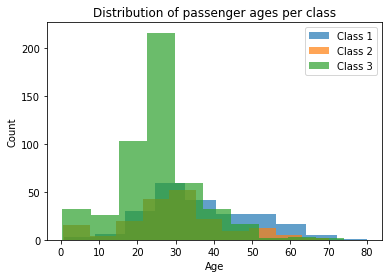

In [21]:
for passenger_class, ages in ages_by_class:
    plt.hist(ages, label = "Class {}".format(passenger_class), alpha = 0.7)
plt.title("Distribution of passenger ages per class")
plt.xlabel("Age")
plt.ylabel("Count")
plt.legend()
plt.show()

We can see something really interesting. It seems that first-class passengers are a little bit older than third-class passengers. But is this really true? We can't tell for sure. First of all, there are many more third-class passengers; and second, we can't be sure whether there's a significant difference or not.

Fortunately, there's a rigorous statistical method to find out. Enter **hypothesis testing**.

### Problem 6. Perform hypothesis testing on age vs. class (1 point)
First, let's store "class 1" and "class 3" passenger ages in their own variables, for easier work.

In [22]:
first_class_ages = ages_by_class.get_group(1)
third_class_ages = ages_by_class.get_group(3)

To perform a hypothesis test, we'll need a hypothesis. Actually, a pair of hypotheses. The "null hypothesis", $H_0$ says that "there's nothing interesting going on with the data". The "alternative hypothesis", $H_1$ says the opposite.

We want to prove whether or not the passenger class is correlated with the age. Therefore:
* $H_0:$ Passenger class is not correlated with age. `first_class_ages` and `third_class_ages` are two samples from the same distribution.
* $H_1:$ `first_class_ages` and `third_class_ages` come from two different distributions.

Ideally, **we'd like to reject the null hypothesis**.

Here's a quick explanation of the process: we'll perform a test. The exact details aren't important. We assume that $H_0$ is true, therefore **the differences between the two histograms occur simply by chance**. The test will return a $p$-value. It corresponds to the probability that we observe **as extreme or more extreme differences** between the two histograms if $H_0$ is really true.

We have to agree on a "threshold value" of $p$. Usually that's 5% (0.05), but let's choose 1% in this case. What does this mean? If we reject $H_0$, there will still be 1% chance that we rejected it wrongly.

**If $p\le1\%$, we will reject $H_0$**.

To compare the two variables, it's easiest to perform what's called a **t-test**. It's already been imported for you. Call it like this: `test_result = ttest_ind(<first_variable>, <second_variable>, equal_var = False)`.

**Note:** You can get additional information about the mechanics of statistical hypothesis testing on the Internet. Research more if you wish. You can also research what `equal_var = False` is and why we aren't allowed to assume equal variances in this case.

In [23]:
test_result = None
test_result = ttest_ind(first_class_ages , third_class_ages, equal_var = False)
print(test_result.pvalue)
if test_result.pvalue <= 0.01:
    print("The differences in age are significant. Reject H0.")
else:
    print("There's not enough evidence to reject H0. Don't accept or reject anything else.")

1.7607348746034483e-20
The differences in age are significant. Reject H0.


In [24]:
assert_is_not_none(test_result)

Therefore, we can conclude that **the distributions of ages are significantly different at the 1% level**. Actually, they're so significantly different, that we might as well have chosen $1.10^{-17}\%$ and still be correct.

This means that ages are different for the different classes. How can we interpret this? Probably wealthier people are older. Younger people might not need, or might not be able to afford, a higher fare.

### Problem 7. Prepare the data for modelling: indicator variables (1 point)
We're going to use `scikit-learn` to model the data. However, that's not so simple. We first need to preprocess the data a little.

Most importantly, all variables should be numeric. `scikit-learn` doesn't know how to deal with text and categories.

We need to convert `Sex` and `Embarked` to categories. There are many ways to do that.

What's considered the best way is via the so-called "indicator variables". These are variables whose values are 0 or 1. For example, let's look at the "Sex" column. It has two possible values: "male" and "female". Each of these values will create a new column: `Sex_male` and `Sex_female`. If the passenger is male, he will have 1 in the `Sex_male` column, and so on. Similarly, with `Embarked`.

There's a really easy way to do this in `pandas`: `pd.get_dummies(dataframe)`. Note that this returns another dataframe. Add the columns: `["Class", "Sex", "Embarked"]` to the dataframe. Write the code and explore the newly created dataset.

In [25]:
titanic_data_for_modelling = None
titanic_data_for_modelling = pd.get_dummies(titanic_data, columns=["Class", "Sex", "Embarked"])
titanic_data_for_modelling.head()

,Survived,Age,SibSp,ParCh,Fare,Class_1,Class_2,Class_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,,,
1,0,22.0,1,0,7.2500,0,0,1,0,1,0,0,1
2,1,38.0,1,0,71.2833,1,0,0,1,0,1,0,0
3,1,26.0,0,0,7.9250,0,0,1,1,0,0,0,1
4,1,35.0,1,0,53.1000,1,0,0,1,0,0,0,1
5,0,35.0,0,0,8.0500,0,0,1,0,1,0,0,1


We can now see that we have more columns. We can also see that since `Sex` has only two possible values, the two columns `Sex_female` and `Sex_male` are just opposites of each other. We can safely remove one of them. However, this is not true for the `Class` and `Embarked` columns.

In [26]:
titanic_data_for_modelling = titanic_data_for_modelling.drop(columns=["Sex_male"])

In [27]:
assert_equal(titanic_data_for_modelling.shape, (891, 12))

Later, it will be really convenient to separate the explanatory variables from the target variable.

We want to predict whether or not a person has survived. Therefore, `Survived` will be our target variable. All other variables will be our explanatory variables (also called features).

In [28]:
titanic_data_features = titanic_data_for_modelling.drop("Survived", axis = 1)
titanic_data_target = titanic_data_for_modelling.Survived

### Problem 8. Prepare the data for modelling: normalization (1 point)
In order for the model to perform better, we usually need to rescale the values for each numeric column. 

Why do we do this? It's related to algorithm stability and convergence. Generally, a machine learning algorithm will perform better if all values are in similar ranges.

Do we always need it? No, but we usually do.

There are many types of normalization. In this case, we're going to use a **min-max normalization**. The minimum value in the column will become 0, the maximum will become 1. All values in between will be scaled accordingly.

`scikit-learn` has a very convenient [MinMaxScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler). You use it by simply instantiating it and passing the data:
```python
scaler = MinMaxScaler()
titanic_data_features_scaled = scaler.fit_transform(titanic_data_features)
```

Note that `titanic_data_scaled` will be a 2D `numpy` array.

In [29]:
titanic_data_scaled = None
scaler = MinMaxScaler()
titanic_data_features_scaled = scaler.fit_transform(titanic_data_features)

C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [30]:
assert_is_not_none(titanic_data_features_scaled)
assert_equal(titanic_data_features_scaled.shape, (891, 11))

### Problem 9. Split the data (0 points)
When we want to evaluate a machine learning model, we usually hide some data from it. We train the model on most of the data, but when we test it afterwards, we pass the additional, hidden data. This is similar to how humans learn - a teacher won't give the exact answers to all students. If this was the case, the teacher cannot know whether a student really learned something, or just memorized all the answers.

The function `train_test_split` from `scikit-learn` will perform the splitting for us. See the docs [here](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).

We usually want $\approx 70\%$ of the data for training and the remaining $\approx 30\%$ for testing. It's very important that the data is shuffled. `train_test_split()` will do this by default.

We'll pass the features and target variables and we'll get the different parts accordingly.

In [31]:
features_train, features_test, target_train, target_test = train_test_split(
    titanic_data_features_scaled, titanic_data_target, train_size = 0.7, test_size = 0.3, random_state = 42)
print(features_train.shape, features_test.shape, target_train.shape, target_test.shape, sep = "\r\n")

(623, 11)
(268, 11)
(623,)
(268,)


### Problem 10. Model the data (1 point)
Let's model the data using logistic regression. That's very simple.

First, create a logistic regression model (with no custom settings). Then, fit the model using the training features and training target.
```python
model = LogisticRegression()
model.fit(???, ???)
```

If you wish, you can inspect the model coefficients and intercept.

In [37]:
model = None
model = LogisticRegression()
model.fit(features_train, target_train)

C:\Users\DSPetrov\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [33]:
assert_is_not_none(model)

### Problem 11. Score the model (1 point)
The default scoring metric for a classification model is **accuracy**. Use `model.score(???, ???)` to get an accuracy score for the model. This should be around 80%.

**Note:** Remember to use `features_test` and `target_test`, not the training subsets.

In [34]:
score = 0
score = model.score(features_test, target_test)

In [35]:
assert_greater(score, 0)
assert_less_equal(score, 1)

In [36]:
score

0.8059701492537313

You see that even though it might seem difficult at first, working with models is pretty easy.

Feature preparation, train / test split, normalization, extraction of explanatory features vs. target, modelling, testing, and evaluating: these are all parts of the data modelling process. It's the basic idea of **machine learning**.

We started from a dataset and we were able to explore, visualize, and model the data. After all this, we have several deliverables: notebook with our research, model (that we might upload somewhere - but that's outside the scope of this lab), (mostly) repeatable research. We have followed a careful and complete process to get to the final results.

We can, of course, extend the study. But this is enough for now.

# Good luck on the exam! :)